In [37]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
import glob
import torch
from torchvision import transforms
from layers import disp_to_depth, BackprojectDepth, Project3D

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [240]:
model_name = "mzg_fullres"
model_name = "mzg_orchard_road"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

/home/zhenghaofei/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/zhenghaofei/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Loading the test image and preprocessing

In [293]:
# image_path = "assets/test_image.jpg"
image_path = "/mnt/TempData/people/zhenghao/SfmLearner/mzg_fullres/train/00006000.jpg"

image_path = "/mnt/TempData/people/zhenghao/SfmLearner/mzg_orchard_road/train/00006200.jpg"



In [294]:

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

/tmp/ipykernel_1179399/1097157920.py:6: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)


## Prediction using the PyTorch model

In [295]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

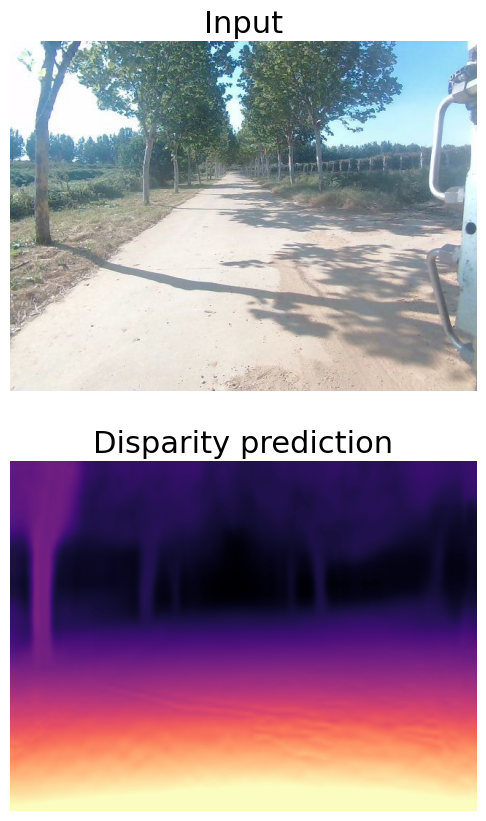

In [296]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [297]:

disp_resized_np.shape

(480, 640)

In [298]:
disp_resized_np

array([[0.28529066, 0.28514457, 0.28523633, ..., 0.19529217, 0.19457185,
        0.19447456],
       [0.28494605, 0.28488   , 0.28492296, ..., 0.19516923, 0.19449122,
        0.19437864],
       [0.28356767, 0.28382182, 0.28366947, ..., 0.19467747, 0.19416869,
        0.19399501],
       ...,
       [0.91227204, 0.91145724, 0.9117884 , ..., 0.93461376, 0.9342452 ,
        0.93416935],
       [0.9119724 , 0.9110638 , 0.91139776, ..., 0.9346542 , 0.93440557,
        0.9342588 ],
       [0.9118975 , 0.91096544, 0.9113001 , ..., 0.93466425, 0.9344456 ,
        0.9342812 ]], dtype=float32)

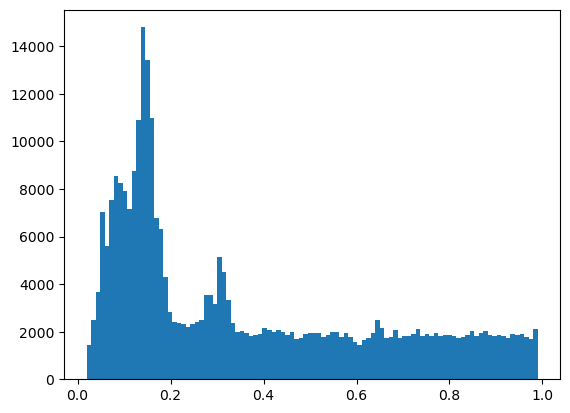

In [299]:
_ = plt.hist(disp_resized_np.flatten(), bins=100)

In [300]:
K = np.array([[0.53398137, 0.        , 0.48660831, 0],
                [0.        , 0.72386856, 0.33451852, 0],
                [0.        , 0.        , 1.        ,0 ],
                [0, 0, 0, 1]], dtype=np.float32)
# scale K to image size
K[0, :] *= original_width
K[1, :] *= original_height
inv_K = np.linalg.pinv(K)
K = torch.from_numpy(K)
inv_K = torch.from_numpy(inv_K).unsqueeze(0)


In [301]:
min_depth = 0.1
max_depth = 100
scaled_disp, depth = disp_to_depth(disp_resized_np, min_depth, max_depth)
depth.shape


(480, 640)

In [302]:
backproject_depth = BackprojectDepth(1, original_height, original_width)


In [303]:
depth_expand = np.expand_dims(depth, axis=0)
depth_expand_tensor = torch.from_numpy(depth_expand)
depth_expand_tensor.shape

torch.Size([1, 480, 640])

In [304]:
backproject_depth.pix_coords.shape

torch.Size([1, 3, 307200])

In [305]:
inv_K.unsqueeze(0).shape

torch.Size([1, 1, 4, 4])

In [306]:
inv_K[:, :3, :3].shape

torch.Size([1, 3, 3])

In [307]:
backproject_depth.pix_coords.shape

torch.Size([1, 3, 307200])

In [308]:
cam_points = torch.matmul(inv_K[:, :3, :3], backproject_depth.pix_coords)
cam_points.shape

torch.Size([1, 3, 307200])

In [309]:
cam_points = backproject_depth(depth_expand_tensor, inv_K)
cam_points.shape

torch.Size([1, 4, 307200])

In [310]:
cam_points_np = cam_points.squeeze().cpu().numpy()


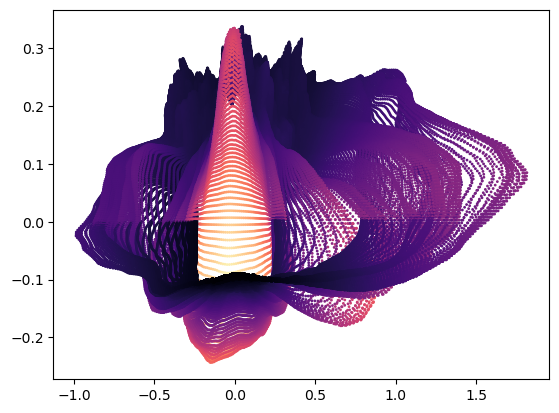

In [311]:
plt.scatter(cam_points_np[0, :], -cam_points_np[1, :], c=cam_points_np[2, :], s=1, cmap='magma')

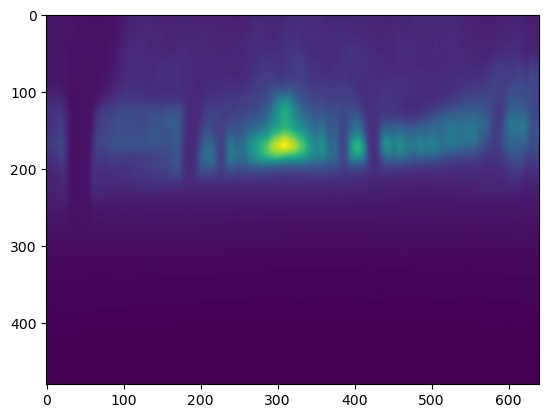

In [318]:
d_map = cam_points_np[2, :].reshape(original_height, original_width)
plt.imshow(d_map)

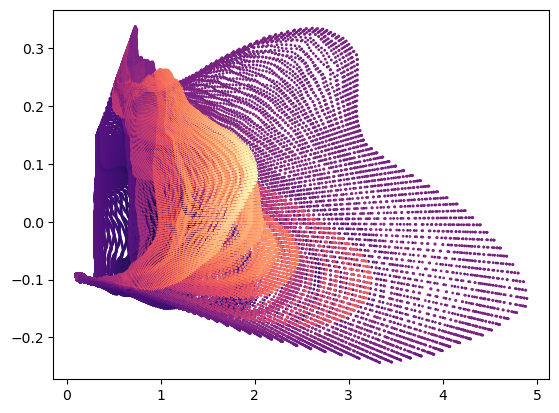

In [319]:
plt.scatter(cam_points_np[2, :], -cam_points_np[1, :], c=cam_points_np[0, :], s=1, cmap='magma')

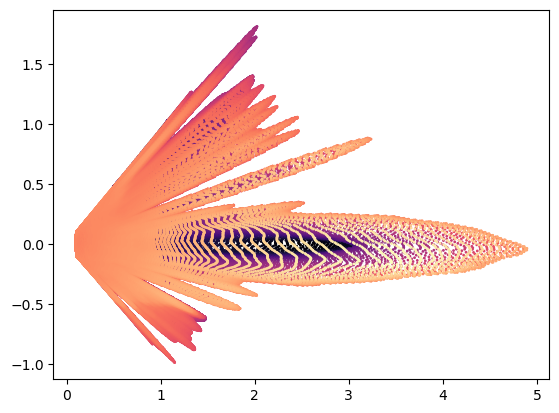

In [320]:
plt.scatter(cam_points_np[2, :], cam_points_np[0, :], c=cam_points_np[1, :], s=1, cmap='magma')

In [327]:
cam_points_cut = cam_points_np.copy()
y_min = -0.0
z_max = 1.0
cam_points_cut = cam_points_cut[:, cam_points_cut[2, :] < z_max]
cam_points_cut = cam_points_cut[:, cam_points_cut[1, :] > y_min]

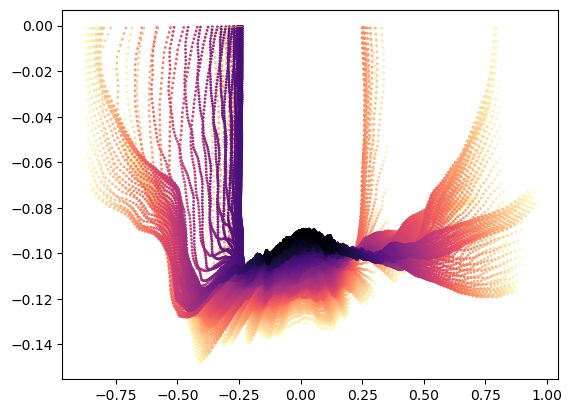

In [328]:
plt.scatter(cam_points_cut[0, :], -cam_points_cut[1, :], c=cam_points_cut[2, :], s=1, cmap='magma')

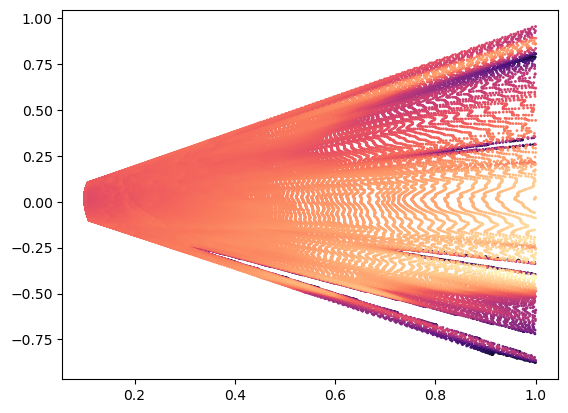

In [329]:
plt.scatter(cam_points_cut[2, :], cam_points_cut[0, :], c=cam_points_cut[1, :], s=1, cmap='magma')